# Initialization

In [ ]:
import csv
from datetime import datetime
import matplotlib.pyplot as plt
import os
import numpy as np
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from math import sqrt
import statsmodels.api as sm
import pandas as pd
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import warnings
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error
from colorama import Fore
import seaborn as sns
plt.rcParams['axes.unicode_minus'] = False


In [ ]:
file_path = # Input your file path

In [ ]:
data = pd.read_csv(file_path + 'data_all.csv')
data = data[data['Country'] == 'Spain'].drop('Country', axis=1)

In [ ]:
data.columns

Index(['Year', 'Target', 'Pesticides indicators (kg/ha)', 'N', 'K2O', 'P2O5',
       'Fertilizer consumption (kilograms per hectare of arable land)',
       'Cropland (1000 ha)', 'Value Added (%GDP)', 'Mean Temperature',
       'Precipitation', 'Share of employment in agriculture', 'fpi',
       'Total Population', 'Agricultural machinery',
       'Export Trade Value (US$)', 'Export Avg Price ($/kg)',
       'Import Trade Value (US$)', 'Import Avg Price ($/kg)', 'Urbanization'],
      dtype='object')

In [ ]:
data = data.drop(['Export Trade Value (US$)', 'Export Avg Price ($/kg)',
       'Import Trade Value (US$)', 'Import Avg Price ($/kg)'], axis = 1)

In [ ]:
# Rename data columns
data.columns = ['Year', 'Production', 'Pesticides', 'Fertilizer (N)', 'Fertilizer (K2O)',
                'Fertilizer (P2O5)', 'Fertilizer (Total)', 'Cropland',
                'Agricultural Value Added', 'Mean Temperature', 'Precipitation',
                'Agricultural Employment', 'FPI', 'Population',
                'Agricultural Machinery', 'Urbanization']


In [ ]:
data['Production'] = data['Production'].astype(float)


# Drop columns with many NaN values

columns_to_drop = ['Pesticides', 'Agricultural Value Added',
                   'Agricultural Employment', 'Agricultural Machinery', ]

data.drop(columns=columns_to_drop, inplace=True)

# Drop the last row (as it contains some NaN values)
data.drop(data.index[-1], inplace=True)

data_year = data.copy()

In [ ]:
data.head(5)

,Year,Production,Fertilizer (N),Fertilizer (K2O),Fertilizer (P2O5),Fertilizer (Total),Cropland,Mean Temperature,Precipitation,FPI,Population,Urbanization
1365,1961,547341.0,327.2,94.7,307.9,44.925274,20730.0,13.82,685.32,36.61,30711.863,1.342102
1366,1962,576366.0,346.0,96.0,311.0,46.157707,20832.0,13.01,716.12,36.15,31052.630,1.398546
1367,1963,585814.0,333.0,100.0,314.0,46.058007,20837.0,12.64,857.94,42.76,31388.554,1.457364
1368,1964,638755.0,364.0,91.0,312.0,48.191406,20553.0,13.27,552.16,39.31,31747.643,1.518742
1369,1965,604179.0,474.0,92.0,306.0,49.001566,20594.0,12.87,671.76,39.47,32112.015,1.582525


# MRMR select feature

In [ ]:
# Drop the 'Year' column
data_without_year = data.drop(columns=['Year'])

from mrmr import mrmr_regression

# Select the top 7 most related variables based on mRMR
selected_features = mrmr_regression(X=data_without_year.drop('Production', axis=1), y=data_without_year["Production"], K = 7, return_scores = False)


100%|██████████| 7/7 [00:00<00:00, 21.33it/s]


In [ ]:
selected_features

['Population',
 'FPI',
 'Urbanization',
 'Cropland',
 'Fertilizer (Total)',
 'Mean Temperature',
 'Fertilizer (K2O)']

mrmr scores:

- **Population**: 528.261164
- **FPI**: 450.737345
- **Urbanization**: 388.863462
- **Cropland (1000 ha)**: 329.473779
- **Total Fertilizer**: 133.290824
- **Mean Temperature**: 91.023472
- **K2O**: 63.534910
- **N**: 55.585354
- **P2O5**: 3.457196
- **Precipitation**: 1.983453


##### Functions

In [ ]:
def plot_moving_average(series, window):
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(14, 5))
    plt.title("Time Series with Moving Average")
    plt.plot(series, label="Original Series", color="blue")
    plt.plot(rolling_mean, label=f"Moving Average (window={window})", color="red")
    plt.legend()
    plt.show()

def plot_moving_variance(series, window):
    rolling_variance = series.rolling(window=window).var()

    plt.figure(figsize=(14, 5))
    plt.title("Time Series with Moving Variance")
    plt.plot(series, label="Original Series", color="blue")
    plt.plot(rolling_variance, label=f"Moving Variance (window={window})", color="orange")
    plt.legend()
    plt.show()


In [ ]:
def teststationarity(ts, name = None):

    dftest = statsmodels.tsa.stattools.adfuller(ts, autolag = 'AIC')

    # Semantic interpretation of the above function's returned values
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value

    print(f"{name}:")

    if(dfoutput['Test Statistic'] < dfoutput['Critical Value (5%)']):
        print(f"Test Statistic = {round(dfoutput['Test Statistic'], 3)} < Critical Value (5%) = {round(dfoutput['Critical Value (5%)'], 3)} \n=> This series is stationary.\n")
    else:
        print(f"Test Statistic = {round(dfoutput['Test Statistic'], 3)} > Critical Value (5%) = {round(dfoutput['Critical Value (5%)'], 3)} \n=> This series is Non-stationary.\n")
    return dfoutput


In [ ]:
# Using AIC and BIC statistics to automatically determine the best model
def proper_model(data_ts, maxLag, d):
    init_bic = float("inf")  # Initialize BIC to a very large value
    init_p = 0               # Initial AR order
    init_q = 0               # Initial MA order
    init_properModel = None  # Initial model

    # Iterate over possible combinations of p and q
    for p in np.arange(maxLag):
        for q in np.arange(maxLag):
            model = ARIMA(data_ts, order=(p, d, q))
            try:
                results_ARIMA = model.fit(disp=-1, method='css')
            except:
                # Skip this combination if the model doesn't converge
                continue
            bic = results_ARIMA.bic
            # If this model's BIC is lower than the previous best, update the best parameters and model
            if bic < init_bic:
                init_p = p
                init_q = q
                init_properModel = results_ARIMA
                init_bic = bic

    return init_bic, init_p, init_q, init_properModel


In [ ]:
from math import ceil

def TestStationaryPlot(df2):
    total_cols = len(df2.columns)
    nrows = ceil(total_cols / 4)  # Calculate the number of rows based on the desired number of columns (4 columns)

    fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(20, 5 * nrows))  # Set to 4 columns, and adjust the figure size accordingly

    # If the number of columns isn't a multiple of 4, hide the extra subplots
    if total_cols % 4 != 0:
        for i in range(4 - (total_cols % 4)):
            fig.delaxes(axes[nrows - 1, - (i + 1)])

    # When there's only one row, axes remains one-dimensional. We need to reshape it to 2D for consistency.
    if nrows == 1:
        axes = axes.reshape(1, -1)

    for i, col in enumerate(df2.columns):
        ax = axes[i // 4, i % 4]  # Indexing based on a total of 4 columns

        # Rolling mean over 12 data points
        rol_mean = df2[col].rolling(window = 12).mean()
        # Rolling standard deviation over 12 data points
        rol_std = df2[col].rolling(window = 12).std()

        ax.plot(df2[col], label='Original', color='blue')
        ax.plot(rol_mean, color='red', linestyle='-.',label='Moving Average Mean')
        ax.plot(rol_std, color='black', linestyle='--',label='Standard Deviation')

        ax.legend(loc='best')
        ax.set_title(f'{col}')
        ax.set_xlabel('Time')

    plt.tight_layout()
    plt.savefig('moving_average.jpeg', dpi=300);


In [ ]:
def check_white_noise_pvalues(df, lags=40, alpha=0.05):

    results = pd.DataFrame(index=df.columns, columns=["p_value", "White Noise?"])

    for col in df.columns:
        lb_test = acorr_ljungbox(df[col], lags=lags)
        min_pvalue = min(lb_test['lb_pvalue'])

        # Store the results in the DataFrame
        results.loc[col, "p_value"] = min_pvalue
        results.loc[col, "White Noise?"] = "No" if min_pvalue < alpha else "Yes"

    return results


In [ ]:
import numpy as np
import statsmodels.api as sm
import itertools

def arimax_grid_search(endog, exog=None, p_range=3, d_range=2, q_range=3):

    # Generate combinations for p, d, q
    pdq_combinations = list(itertools.product(range(1,p_range), range(d_range), range(1,q_range)))

    best_aic = np.inf
    best_bic = np.inf
    best_order = None
    best_model = None

    for order in pdq_combinations:
        try:
            model = sm.tsa.ARIMA(endog, exog=exog, order=order)
            results = model.fit()

            # Print the AIC and BIC values for each model
            print(f"ARIMAX{order} - AIC: {results.aic}, BIC: {results.bic}")

            # Check if this model has a lower combined AIC and BIC than previous models
            if (results.aic + results.bic) < (best_aic + best_bic):
                best_aic = results.aic
                best_bic = results.bic
                best_order = order
                best_model = results
        except:
            # In case the model cannot be fit with certain parameters
            continue

    print(f"\nThe best model is ARIMAX{best_order} with AIC: {best_aic} and BIC: {best_bic}")
    return best_model, best_aic, best_bic


# ARIMAX

#### Stationary test

In [ ]:
feature_order = ['Production'] + selected_features
data_without_year = data_without_year[feature_order]

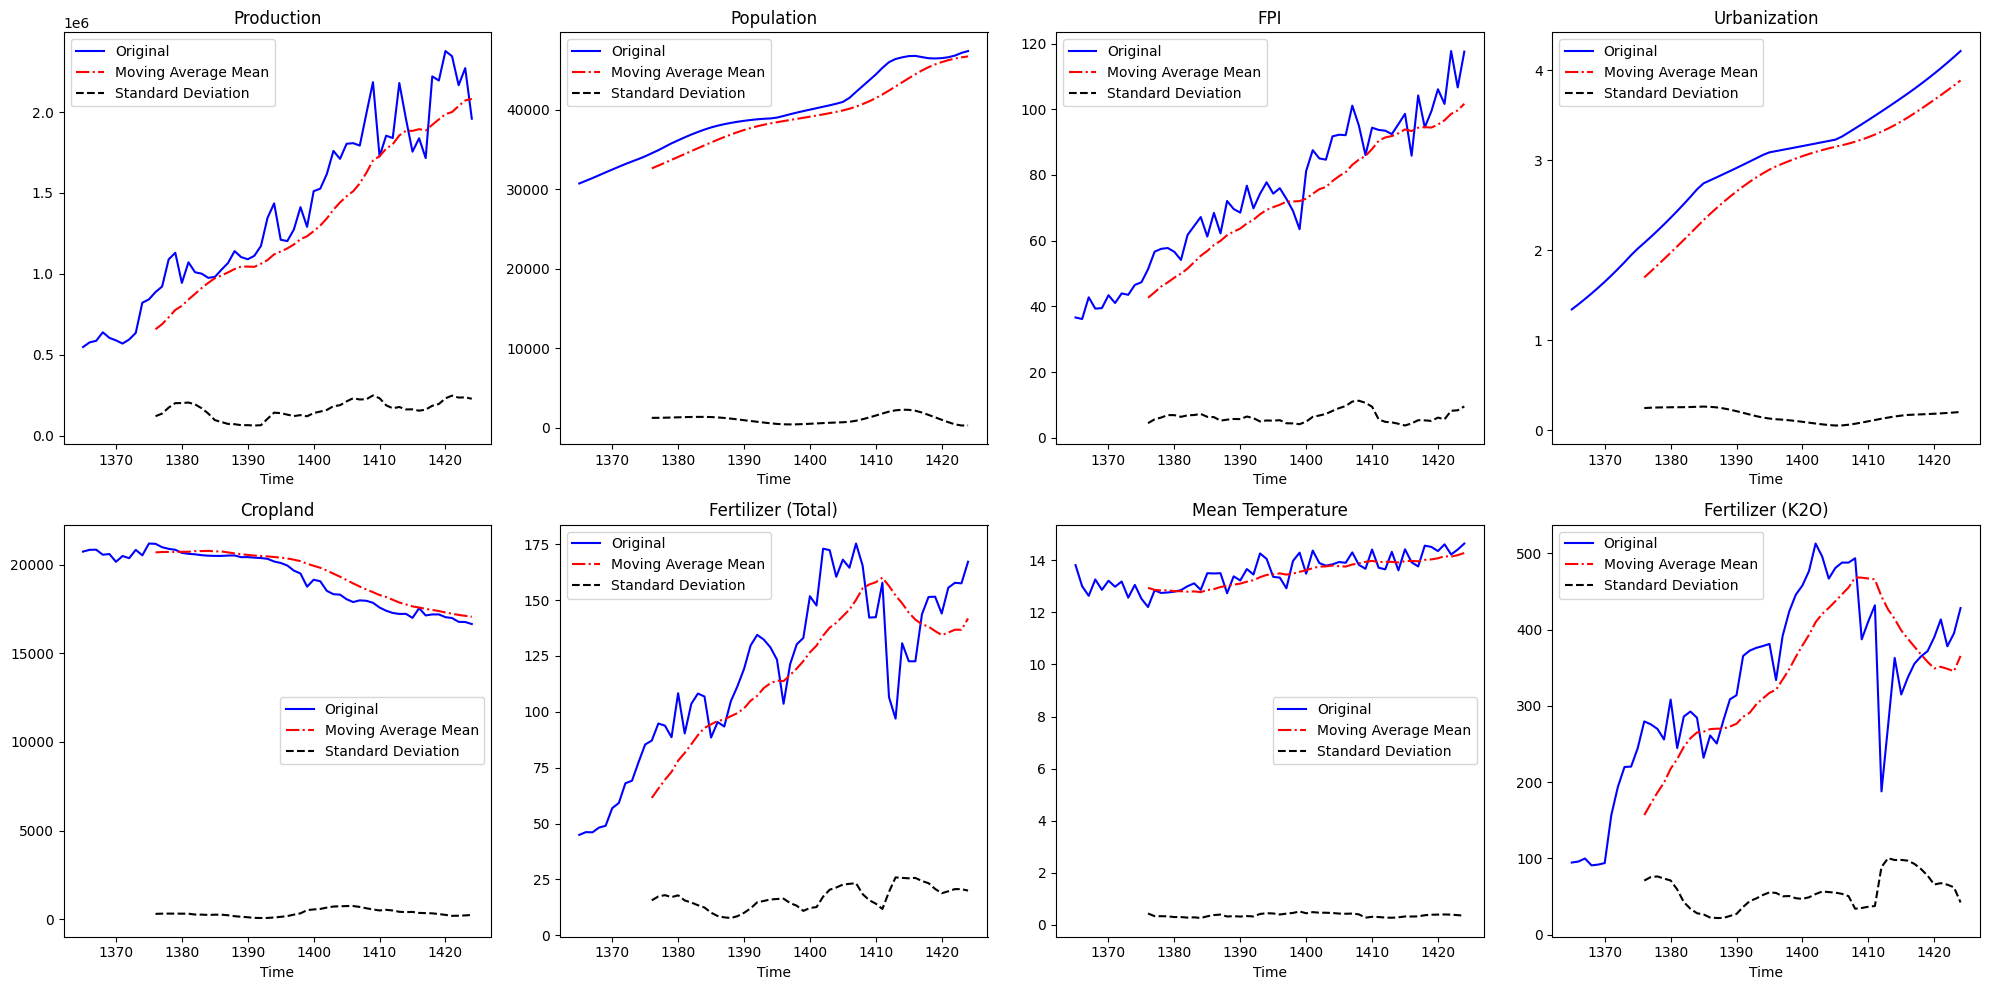

In [ ]:
TestStationaryPlot(data_without_year)

In [ ]:
print(f"ADF Test for Stationarity:\n")

for name, column in data_without_year.items():
    teststationarity(column, name=column.name)

ADF Test for Stationarity:

Production:
Test Statistic = -0.566 > Critical Value (5%) = -2.918 
=> This series is Non-stationary.

Population:
Test Statistic = -1.236 > Critical Value (5%) = -2.919 
=> This series is Non-stationary.

FPI:
Test Statistic = -0.784 > Critical Value (5%) = -2.921 
=> This series is Non-stationary.

Urbanization:
Test Statistic = -0.463 > Critical Value (5%) = -2.914 
=> This series is Non-stationary.

Cropland:
Test Statistic = 0.78 > Critical Value (5%) = -2.913 
=> This series is Non-stationary.

Fertilizer (Total):
Test Statistic = -1.791 > Critical Value (5%) = -2.915 
=> This series is Non-stationary.

Mean Temperature:
Test Statistic = -0.501 > Critical Value (5%) = -2.924 
=> This series is Non-stationary.

Fertilizer (K2O):
Test Statistic = -2.252 > Critical Value (5%) = -2.915 
=> This series is Non-stationary.



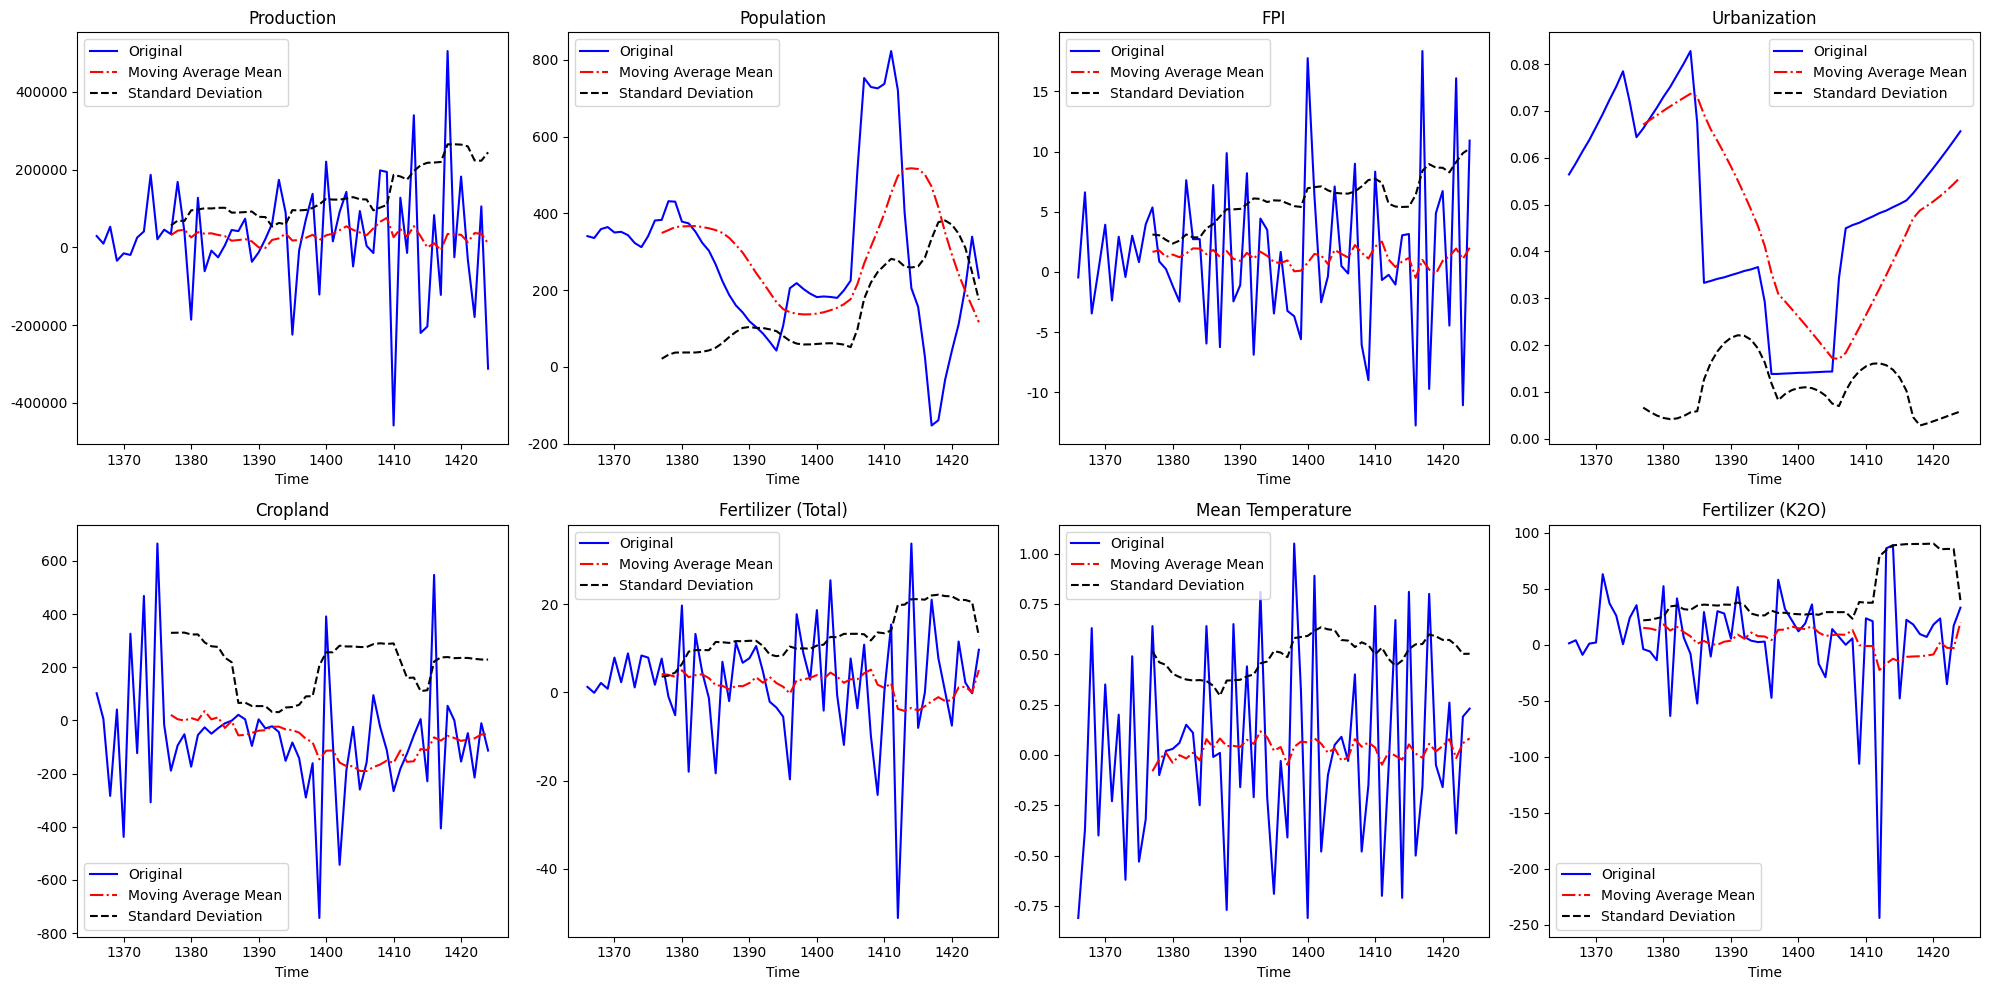

In [ ]:
# First Order Differencing

data_diff = data_without_year.diff().dropna()
TestStationaryPlot(data_diff)



In [ ]:
for name, column in data_diff.items():
    teststationarity(column, name=column.name)

Production:
Test Statistic = -4.268 < Critical Value (5%) = -2.918 
=> This series is stationary.

Population:
Test Statistic = -3.594 < Critical Value (5%) = -2.925 
=> This series is stationary.

FPI:
Test Statistic = -3.757 < Critical Value (5%) = -2.921 
=> This series is stationary.

Urbanization:
Test Statistic = -1.722 > Critical Value (5%) = -2.914 
=> This series is Non-stationary.

Cropland:
Test Statistic = -10.647 < Critical Value (5%) = -2.913 
=> This series is stationary.

Fertilizer (Total):
Test Statistic = -3.95 < Critical Value (5%) = -2.915 
=> This series is stationary.

Mean Temperature:
Test Statistic = -3.271 < Critical Value (5%) = -2.924 
=> This series is stationary.

Fertilizer (K2O):
Test Statistic = -4.018 < Critical Value (5%) = -2.915 
=> This series is stationary.



In [ ]:
#### drop urbanization for not stationary at 1st differenatino
data_diff.drop('Urbanization',axis=1,inplace=True)

In [ ]:
##### white noise test

check_white_noise_pvalues(data_diff)

,p_value,White Noise?
Production,0.005149,No
Population,0.0,No
FPI,0.0,No
Cropland,0.006356,No
Fertilizer (Total),0.018143,No
Mean Temperature,0.000034,No
Fertilizer (K2O),0.002592,No


In [ ]:
data = data_without_year

#### ACF and APCF analysis

<Figure size 640x480 with 0 Axes>

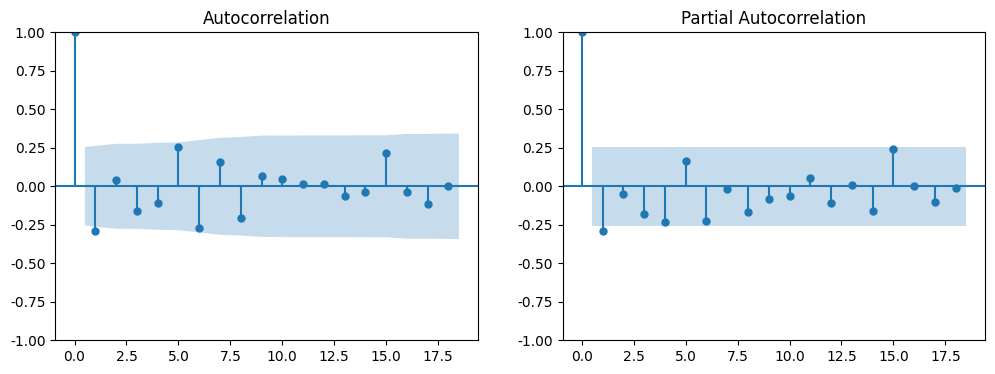

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure()
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))
plot_acf(data_diff['Production'], ax = ax[0])
plot_pacf(data_diff['Production'], ax = ax[1])
plt.savefig('acf',dpi=300)
plt.show()

#### Grid Search with exo variable

In [ ]:
data_copy = data_without_year.drop(data_without_year.index[0])

In [ ]:
selected_features.remove('Urbanization')

In [ ]:
#### grid search with the training data

grid = arimax_grid_search(data_copy['Production'].iloc[0:49],data_diff[selected_features].iloc[0:49])

ARIMAX(1, 0, 1) - AIC: 1338.649071027969, BIC: 1357.5672740090754
ARIMAX(1, 0, 2) - AIC: 1344.6290455145263, BIC: 1365.4390687937432
ARIMAX(1, 1, 1) - AIC: 1277.6190008652236, BIC: 1294.4598099633947
ARIMAX(1, 1, 2) - AIC: 1279.6386760893208, BIC: 1298.3506861983997
ARIMAX(2, 0, 2) - AIC: 1342.2167182756198, BIC: 1364.9185618529473
ARIMAX(2, 1, 1) - AIC: 1279.5745561293347, BIC: 1298.2865662384136
ARIMAX(2, 1, 2) - AIC: 1279.108607662052, BIC: 1299.6918187820388

The best model is ARIMAX(1, 1, 1) with AIC: 1277.6190008652236 and BIC: 1294.4598099633947


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Extract residuals as a DataFrame
residuals_df = pd.DataFrame(grid[0].resid)

# Apply the function
white_noise_results = check_white_noise_pvalues(residuals_df)

# Display the results
print(white_noise_results)

    p_value White Noise?
0  0.597514          Yes


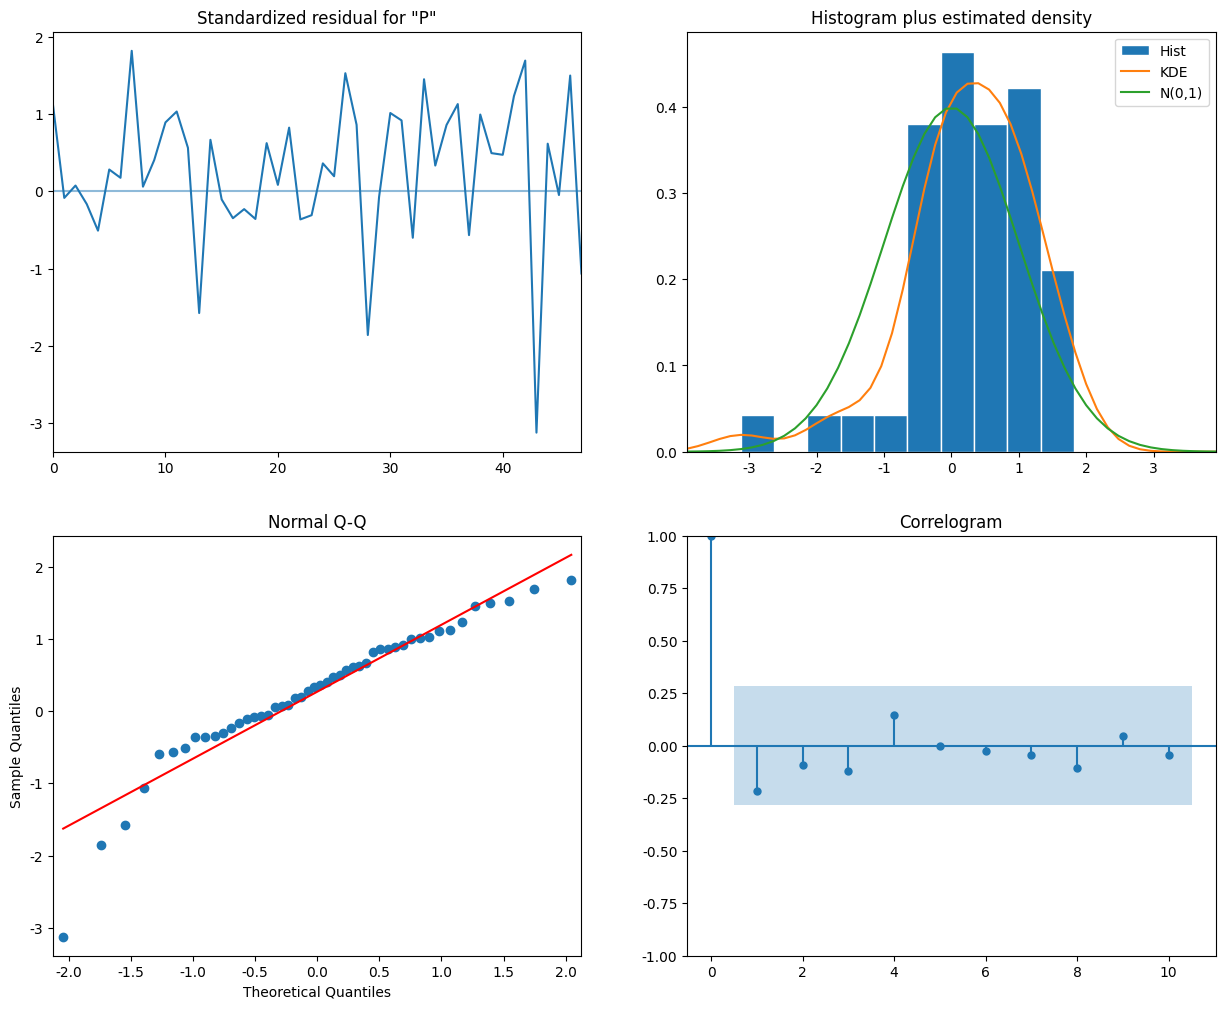

In [ ]:
grid[0].plot_diagnostics(figsize=(15, 12))

plt.savefig('diagonosis',dpi=300)


#### Model Performance

In [ ]:
data_year = data_year.drop(data_year.index[0])

In [ ]:
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA


# 0. Combine 'Production' and the first difference of the selected exogenous variables. Drop the first row.
merged_df = pd.concat([data_year[['Production']],data_diff[selected_features]],axis=1)

# 1. Standardize the data.
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(merged_df), columns=merged_df.columns)

# 2. Split the standardized data into training and test sets.
tr_scaled = data_scaled[0:49]
ts_scaled = data_scaled[48:59]

# 3. Use the standardized data to fit the model and make predictions.
exog_columns = selected_features

exx_scaled = tr_scaled[exog_columns]
testex_scaled = ts_scaled[exog_columns]

fit1 = ARIMA(tr_scaled['Production'], order=(1,1,1), exog=exx_scaled).fit()

In [ ]:
ts_scaled = ts_scaled.iloc[1:]

In [ ]:
# Predict using the model.
ts_scaled['ARIMAX'] = fit1.predict(start=48, end=59, dynamic=True, exog=testex_scaled)

In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate error metrics
predicted_values = ts_scaled['ARIMAX'].values
actual_values = ts_scaled['Production'].values

# MAPE (Mean Absolute Percentage Error)
test_mape = np.mean(np.abs((predicted_values - actual_values) / actual_values))
# MSE (Mean Squared Error)
test_mse = mean_squared_error(actual_values, predicted_values)
# RMSE (Root Mean Squared Error)
test_rmse = np.sqrt(test_mse)
# MAE (Mean Absolute Error)
test_mae = np.mean(np.abs(predicted_values - actual_values))

print('Test MAPE for ARIMAX:', test_mape)
print('Test MSE for ARIMAX:', test_mse)
print('Test RMSE for ARIMAX:', test_rmse)
print('Test MAE for ARIMAX:', test_mae)


Test MAPE for ARIMAX: 0.4323165817234337
Test MSE for ARIMAX: 0.2367419725418368
Test RMSE for ARIMAX: 0.4865613759248023
Test MAE for ARIMAX: 0.3881175151467895


In [ ]:
train = list(tr_scaled['Production'].values) # 0:44
test = list(ts_scaled['Production'].values) #45:58
pred = list(ts_scaled['ARIMAX'].values)

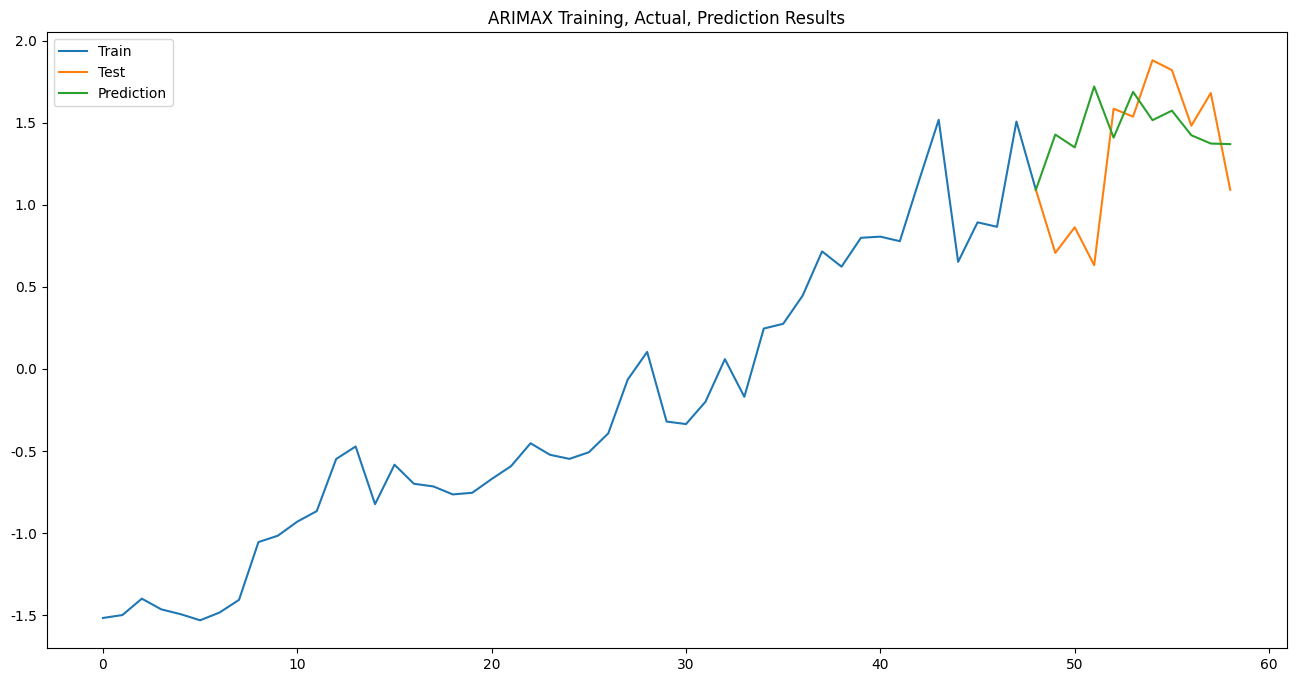

In [ ]:
# Plot the results.
plt.figure(figsize=(16, 8))

# Plot the training data.
pd.Series(train).plot(label = 'Train')
pd.Series([train[-1]] + test, index = range(48, 59)).plot(label = 'Test')
pd.Series([train[-1]] + pred, index = range(48, 59)).plot(label = 'Prediction');

plt.legend(loc='best')
plt.title("ARIMAX Training, Actual, Prediction Results")
plt.savefig('arimax',dpi=300)
plt.show()

In [ ]:
# Reverse the standardization process to get the actual values.

# Create a template dataframe for inverse transformation
temp_actual = pd.DataFrame(np.zeros(shape=(len(ts_scaled), data_scaled.shape[1])), columns=data_scaled.columns)
temp_actual['Production'] = ts_scaled['Production'].values

temp_predicted = temp_actual.copy()
temp_predicted['Production'] = ts_scaled['ARIMAX'].values

actual_inverse_df = pd.DataFrame(scaler.inverse_transform(temp_actual), columns=data_scaled.columns)
predicted_inverse_df = pd.DataFrame(scaler.inverse_transform(temp_predicted), columns=data_scaled.columns)

actual_inverse = actual_inverse_df['Production']
predicted_inverse = predicted_inverse_df['Production']

# Store results in a new DataFrame.
results_df = pd.DataFrame()

# Determine the starting position of ts_scaled in data_year based on the length.
start_pos = len(data_year) - len(ts_scaled)

# Extract the required years using positional indexing.
results_df['Year'] = data_year['Year'].iloc[start_pos:start_pos+len(ts_scaled)].values

results_df['Actual Value'] = actual_inverse.values
results_df['Predicted Value'] = predicted_inverse.values


# Round off and convert the actual values to integers
results_df['Actual Value'] = results_df['Actual Value'].round().astype(int)
results_df['Predicted Value'] = results_df['Predicted Value'].round().astype(int)

print(results_df)

   Year  Actual Value  Predicted Value
0  2011       1755180          2137289
1  2012       1837976          2095812
2  2013       1715517          2292573
3  2014       2220651          2127352
4  2015       2195133          2275290
5  2016       2377205          2183784
6  2017       2345375          2214513
7  2018       2166017          2135088
8  2019       2271379          2108346
9  2020       1959027          2106419


# LSTM

In [ ]:
np.array(data_scaled).shape

(59, 7)

In [ ]:
def rolling_window(df, time_steps):

  X = []
  Y = []

  for i in range(len(df) - time_steps):
      X.append(df[i:i + time_steps])
      Y.append(df[i + time_steps][0])

  X = np.array(X)
  Y = np.array(Y)

  return X, Y
# Number of time steps to consider in each sequence

time_steps = 2

X, Y = rolling_window(np.array(data_scaled), time_steps)
print(X[0])
print('\n')
print(X[1])
print('\n')
print(X.shape)
print(Y[0])
print('\n')
print(Y.shape)

[[-1.51809993  0.28383771 -0.28479716  0.75641323 -0.06596059 -1.73321714
  -0.09378117]
 [-1.50026545  0.26035214  0.81416159  0.32787213 -0.17068068 -0.80778898
  -0.03565144]]


[[-1.50026545  0.26035214  0.81416159  0.32787213 -0.17068068 -0.80778898
  -0.03565144]
 [-1.40033158  0.37268814 -0.7495619  -0.94891529  0.00486506  1.29545682
  -0.31553533]]


(57, 2, 7)
-1.4003315793815765


(57,)


In [ ]:
from sklearn.model_selection import train_test_split

X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size = 0.2, shuffle=False)
print(X_tr.shape, X_ts.shape, Y_tr.shape, Y_ts.shape)

(45, 2, 7) (12, 2, 7) (45,) (12,)


## Tune HP

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# Define the LSTM model as a function with the number of layers as a parameter
def create_lstm_model(units=50, activation='relu', dropout=0.0, optimizer='adam', num_layers=1):
    model = keras.Sequential()
    for _ in range(num_layers):
        model.add(layers.LSTM(units=units, activation=activation, dropout=dropout, return_sequences=True))
    model.add(layers.LSTM(units=units, activation=activation, dropout=dropout))
    model.add(layers.Dense(1))  # Output layer
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

# Create a parameter grid for GridSearchCV
param_grid = {
    'units': [32, 64, 128],
    'activation': ['relu', 'tanh'],
    'dropout': [0.0, 0.1, 0.2],
    'optimizer': ['adam', 'rmsprop'],
    'num_layers': [1, 2, 3]
}

# Initialize the LSTM model
lstm_model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0)

# Perform time series cross-validation
tscv = TimeSeriesSplit(n_splits=3)
grid_search = GridSearchCV(estimator=lstm_model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_tr, Y_tr)

# Get the best model
best_lstm_model = grid_search.best_estimator_

# Train the best model on the full training set
best_lstm_model.fit(X_tr, Y_tr, epochs=100, batch_size=32, verbose=0)

# Evaluate the model on the test set
Y_pred = best_lstm_model.predict(X_ts)
test_mse = mean_squared_error(Y_ts, Y_pred)
test_mae = mean_absolute_error(Y_ts, Y_pred)

print("Best Hyperparameters:", grid_search.best_params_)
print("Test MSE:", test_mse)
print("Test MAE:", test_mae)

Best Hyperparameters: {'activation': 'tanh', 'dropout': 0.1, 'num_layers': 1, 'optimizer': 'rmsprop', 'units': 128}
Test MSE: 0.15040900230588944
Test MAE: 0.33619994966416994


In [ ]:
best_lstm_model.model.save(file_path + 'best_lstm_model.h5')

## Different Window Length

In [ ]:
mse_lst = []
mae_lst = []

# Loop through different window lengths
for window_length in range(1, 16):
    print(f"Window Length: {window_length}")  # Print progress

    # Create rolling windows
    X, Y = rolling_window(np.array(data_scaled), window_length)

    # Split data into training and testing sets
    X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.2, shuffle=False)

    mse_avg_lst = []
    mae_avg_lst = []

    # Repeat the training and evaluation process 3 times
    for _ in range(5):

        best_lstm_model = grid_search.best_estimator_
        best_lstm_model.fit(X_tr, Y_tr, epochs=100, batch_size=32, verbose=0)

        # Evaluate the model on the test set
        Y_pred = best_lstm_model.predict(X_ts)

        test_mse = mean_squared_error(Y_ts, Y_pred)
        test_mae = mean_absolute_error(Y_ts, Y_pred)

        mse_avg_lst.append(test_mse)
        mae_avg_lst.append(test_mae)

    # Calculate and store the average MSE for this window length
    mse_lst.append(np.mean(mse_avg_lst))
    mae_lst.append(np.mean(mae_avg_lst))
    print(f"Average Test MSE: {np.mean(mse_avg_lst)}, Average Test MAE: {np.mean(mae_avg_lst)}\n")  # Print progress

Window Length: 1
Average Test MSE: 0.39387759675675643, Average Test MAE: 0.49826247477991936

Window Length: 2
Average Test MSE: 0.25869978947692307, Average Test MAE: 0.40046161065861996

Window Length: 3
Average Test MSE: 0.31965078547908166, Average Test MAE: 0.49754516367831236

Window Length: 4
Average Test MSE: 0.2875602077825035, Average Test MAE: 0.4505626069436458

Window Length: 5
Average Test MSE: 0.3338252920046581, Average Test MAE: 0.520402952991704

Window Length: 6
Average Test MSE: 0.25268330262685923, Average Test MAE: 0.4284466940464859

Window Length: 7
Average Test MSE: 0.269779892374263, Average Test MAE: 0.45749632986082334

Window Length: 8
Average Test MSE: 0.2123326837391971, Average Test MAE: 0.386776305635599

Window Length: 9
Average Test MSE: 0.20782036818933455, Average Test MAE: 0.3767737578823124

Window Length: 10
Average Test MSE: 0.24801958384934514, Average Test MAE: 0.39807755766903785

Window Length: 11
Average Test MSE: 0.3455734871461124, Avera

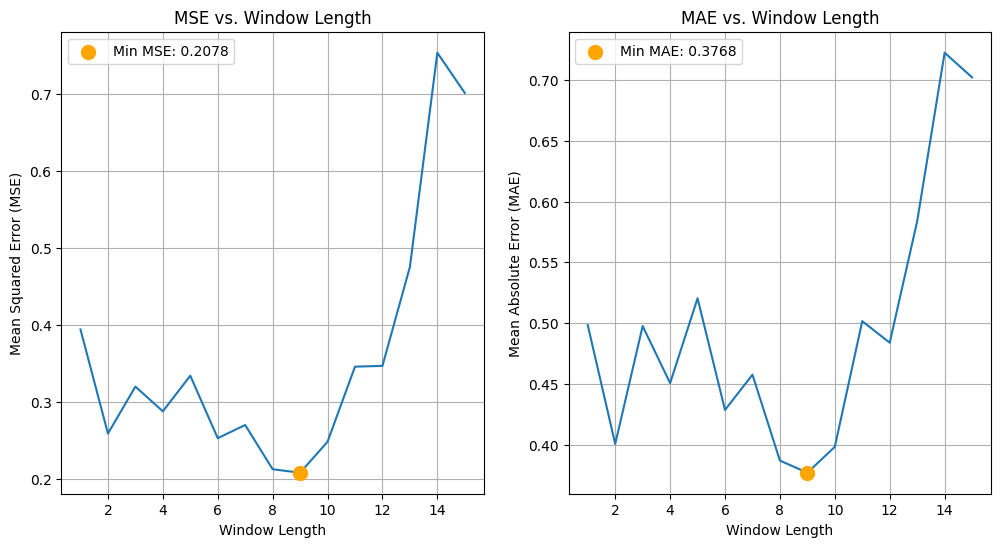

In [ ]:
window_lengths = range(1, 16)  # Assuming you have 10 window lengths

# Find the index with the minimum MSE and MAE
min_mse_index = np.argmin(mse_lst)
min_mse_value = mse_lst[min_mse_index]
min_mae_index = np.argmin(mae_lst)
min_mae_value = mae_lst[min_mae_index]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].plot(window_lengths, mse_lst, linestyle='-')
ax[0].scatter(min_mse_index + 1, min_mse_value, color='orange', label=f'Min MSE: {min_mse_value:.4f}', zorder=10, s = 100)
ax[0].set_title('MSE vs. Window Length')
ax[0].set_xlabel('Window Length')
ax[0].set_ylabel('Mean Squared Error (MSE)')
ax[0].grid(True)  # Add a grid to the plot
ax[0].legend()

ax[1].plot(window_lengths, mae_lst, linestyle='-')
ax[1].scatter(min_mae_index + 1, min_mae_value, color='orange', label=f'Min MAE: {min_mae_value:.4f}', zorder=10, s = 100)
ax[1].set_title('MAE vs. Window Length')
ax[1].set_xlabel('Window Length')
ax[1].set_ylabel('Mean Absolute Error (MAE)')
ax[1].grid(True)  # Add a grid to the plot
ax[1].legend()
plt.savefig(file_path + 'lstm_rolling_window.png',dpi=300);

# Result Comparison

In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate error metrics
predicted_values = ts_scaled['ARIMAX'].values
actual_values = ts_scaled['Production'].values

# MAPE (Mean Absolute Percentage Error)
test_mape = np.mean(np.abs((predicted_values - actual_values) / actual_values))
# MSE (Mean Squared Error)
test_mse = mean_squared_error(actual_values, predicted_values)
# RMSE (Root Mean Squared Error)
test_rmse = np.sqrt(test_mse)
# MAE (Mean Absolute Error)
test_mae = np.mean(np.abs(predicted_values - actual_values))

print('Test MAPE for ARIMAX:', test_mape)
print('Test MSE for ARIMAX:', test_mse)
print('Test RMSE for ARIMAX:', test_rmse)
print('Test MAE for ARIMAX:', test_mae)


Test MAPE for ARIMAX: 0.4323165817234337
Test MSE for ARIMAX: 0.2367419725418368
Test RMSE for ARIMAX: 0.4865613759248023
Test MAE for ARIMAX: 0.3881175151467895


In [ ]:
train = list(tr_scaled['Production'].values) # 0:44
test = list(ts_scaled['Production'].values)  #45:58
pred = list(ts_scaled['ARIMAX'].values)

In [ ]:
# LSTM prediction
# Create rolling windows
X, Y = rolling_window(np.array(data_scaled), 9)

# Split data into training and testing sets
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.2, shuffle=False)

best_lstm_model = grid_search.best_estimator_
best_lstm_model.fit(X_tr, Y_tr, epochs=100, batch_size=32, verbose=0)

# Evaluate the model on the test set
Y_pred = best_lstm_model.predict(X_ts)

lstm_test_mse = mean_squared_error(Y_ts, Y_pred)
lstm_test_mae = mean_absolute_error(Y_ts, Y_pred)

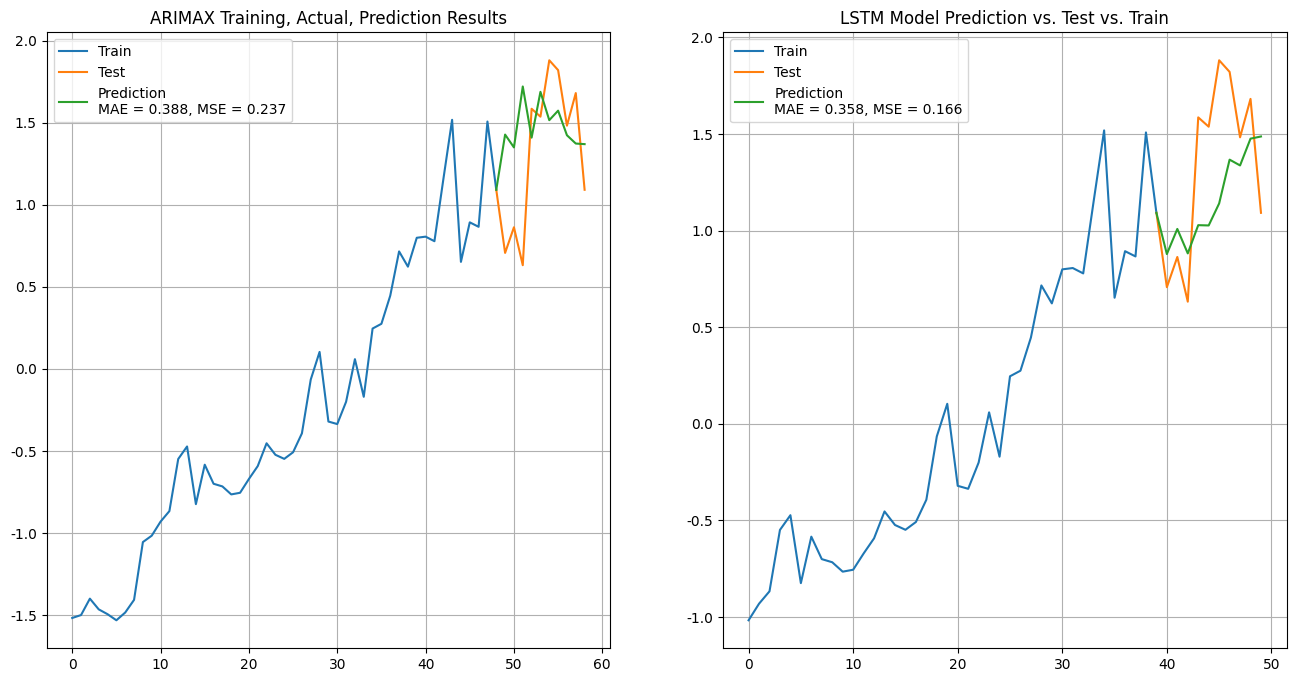

In [ ]:
# Plot the results
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(16, 8))

# Plot the training data.
pd.Series(train).plot(label = 'Train', ax = ax[0])
pd.Series([train[-1]] + test, index = range(48, 59)).plot(label = 'Test', ax = ax[0])
pd.Series([train[-1]] + pred, index = range(48, 59)).plot(label = f'Prediction\nMAE = {test_mae:.3f}, MSE = {test_mse:.3f}', ax = ax[0])

ax[0].legend(loc='best')
ax[0].set_title("ARIMAX Training, Actual, Prediction Results")

# Plot for LSTM
# Plot the training data
pd.Series(Y_tr).plot(label='Train', ax = ax[1])

# Plot the test data
Y_ts_plot = [Y_tr[-1]] + list(Y_ts)
Y_ts_plot = pd.Series(Y_ts_plot, index=range(pd.Series(Y_tr).index[-1], pd.Series(Y_tr).index[-1] + len(Y_ts_plot)))
Y_ts_plot.plot(label='Test', ax = ax[1])

# Plot the LSTM predictions
lstm_pred_plot = [Y_tr[-1]] + list(Y_pred)
lstm_pred_plot = pd.Series(lstm_pred_plot, index=range(pd.Series(Y_tr).index[-1], pd.Series(Y_tr).index[-1] + len(lstm_pred_plot)))

lstm_pred_plot.plot(label = f'Prediction\nMAE = {lstm_test_mae:.3f}, MSE = {lstm_test_mse:.3f}', ax = ax[1])

# Add labels and title
ax[1].set_title('LSTM Model Prediction vs. Test vs. Train')
ax[1].legend()

# Add grid
ax[0].grid(True)
ax[1].grid(True)
plt.savefig(file_path + 'time_series_performance.png',dpi=300)